![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import math
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [53]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1).astype(int)

In [54]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [55]:
# Celda 1

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):    
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)        
            if gain > best_split[2]:
                best_split = [j, split, gain]    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=None):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree


def tree_predict(X, tree, proba=False):
    predicted = np.ones(X.shape[0])
    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']  
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
    return predicted

# Entrenamiento y ajuste del arbol
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=10, num_pct=10)
y_pred = tree_predict(X_test, tree)
y_true = y_test

mse1 = mean_squared_error(y_true, y_pred)
r21 = r2_score(y_true, y_pred)
rmse1 = np.sqrt(mse1)
mae1 = mean_absolute_error(y_true, y_pred)
mape1 =np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Medidas desempeño MSE: {:.2f}, R2: {:.2f},RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(mse1, r21,rmse1, mae1,mape1))


Medidas desempeño MSE: 214722281.42, R2: -13.04,RMSE: 14653.41, MAE: 13877.51, MAPE: 95.31


### Comentarios sobre el desempeño del modelo - Punto 1


- El coeficiente de determinación R2 indica obtenido el cual corresponde a -13.04 indica que el modelo no es util para realizar predicciones precisas respecto a el precio del carro-
- El error cuadratico obtenido 14563 indica que el modelo tiene una alto grado de error y no es preciso.

De acuerdo con los resultados obtenidos se debe realizar un analisis de cada variable que compone el dataframe para validar cuales son las mejores variables para aplicar un modelo con mejores resultados, ya que usando todas las variables predictoras no se obriene un modelo muy preciso 

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [56]:
# Celda 2
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 21)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=20, replace=True))



Arreglo: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Muestreo aleatorio:  [ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


In [57]:
# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [58]:
# Visualización muestra boostrap #1 para entremiento
X_train.iloc[samples[0], :]

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
151599,2016,40999,0,0,0,0,0,1,0
171999,2014,52527,0,0,0,0,0,1,0
304172,2009,123202,0,1,0,0,0,0,0
74828,2015,38807,0,0,0,0,0,1,0
192974,2005,51260,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
134843,2014,22221,0,0,0,0,1,0,0
325075,2013,86593,0,0,0,0,0,1,0
61213,2014,28044,0,0,0,0,0,1,0
181222,2016,49368,0,0,0,0,0,0,1


In [59]:
# Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    XX_train = X_train.iloc[sample, :]
    yy_train = y_train.iloc[sample]
    treereg.fit(XX_train, yy_train)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0
...,...,...,...,...,...,...,...,...,...,...
144298,13836.0,14800.0,14800.0,14800.0,14800.0,14681.0,14800.0,14800.0,13836.0,13836.0
364521,15999.0,14995.0,15999.0,16900.0,15999.0,15999.0,17300.0,15999.0,16900.0,15000.0
120072,23533.0,23533.0,20000.0,17700.0,17700.0,23533.0,17700.0,23533.0,23533.0,20000.0
99878,12989.0,12995.0,12989.0,12995.0,12991.0,12991.0,10995.0,12991.0,12991.0,12893.0


In [60]:
# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))

Árbol  0 tiene un error:  2141.613353645869
Árbol  1 tiene un error:  2136.3519863123465
Árbol  2 tiene un error:  2122.718759132052
Árbol  3 tiene un error:  2087.278992468617
Árbol  4 tiene un error:  2168.518742842026
Árbol  5 tiene un error:  2113.8811455834793
Árbol  6 tiene un error:  2127.933470769012
Árbol  7 tiene un error:  2184.414847251443
Árbol  8 tiene un error:  2138.1071697514985
Árbol  9 tiene un error:  2132.097520859104


In [61]:
# Predicciones promedio para cada obserbación del set de test
y_pred.mean(axis=1)

257343    13767.4
326011     6243.1
242354    16694.3
266376    20865.3
396954    16468.1
           ...   
144298    14498.9
364521    16109.0
120072    21076.5
99878     12782.0
387162    11957.4
Length: 3464, dtype: object

In [62]:
Ypred2=y_pred.mean(axis=1)
Ypred2

257343    13767.4
326011     6243.1
242354    16694.3
266376    20865.3
396954    16468.1
           ...   
144298    14498.9
364521    16109.0
120072    21076.5
99878     12782.0
387162    11957.4
Length: 3464, dtype: object

In [63]:
# Error al promediar las predicciones de todos los árboles

mse_bm = mean_squared_error(y_true, Ypred2)
r2_bm = r2_score(y_true, Ypred2)
rmse_bm = np.sqrt(mse_bm)
mae_bm = mean_absolute_error(y_true, Ypred2)
mape_bm =np.mean(np.abs((y_true - Ypred2) / y_true)) * 100

print("Medidas desempeño Bagging Manual MSE: {:.2f}, R2: {:.2f},RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(mse_bm, r2_bm,rmse_bm, mae_bm,mape_bm))

Medidas desempeño Bagging Manual MSE: 3227180.82, R2: 0.79,RMSE: 1796.44, MAE: 1340.02, MAPE: 9.76


### Comentarios sobre el desempeño del modelo - Punto 2


De acuerdo con el modelo Bagging Manual y sus medidas de desempeño se puede concluir:
    
* El valor obtenido de R2 es alto (0.79), lo que indica que el modelo es  bueno para hacer predicciones.

* En este caso, el valor del RMSE es relativamente bajo (1796.44), lo que indica que el modelo tiene un bajo grado de error y es bastante preciso.

* Un valor bajo del MAE (como en este caso, 1340.02) sugiere que el modelo es bastante preciso.

* El valor bajo del MAPE (9.76) sugiere que el modelo tiene una precisión bastante buena y es confiable para hacer predicciones precisas.


Al usar Bagging, se pueden reducir el sesgo y la varianza del modelo, lo que puede conducir a mejores resultados; con los resultados del modelo; se puede indicar que éste es bastante preciso y confiable para hacer predicciones precisas. 

Además, el uso de la técnica de Bagging puede haber ayudado a mejorar la precisión del modelo frente al anterior. Sin embargo, se deben realizar análisis adicionales para determinar si se pueden mejorar aún más los resultados del modelo y para identificar qué factores están afectando el rendimiento del modelo actual.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [64]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt


#### Creación modelo Bagging con base de árbol de regresión :

En este código, estamos utilizando un modelo base de árbol de regresión (DecisionTreeRegressor) y lo envolvemos en un modelo de Bagging (BaggingRegressor) con 10 estimadores y max_features='log2', que equivale a log(n_features).

Después de entrenar y evaluar el modelo, es posible observar el error cuadrático medio (MSE) como una medida del desempeño del modelo, un MSE más bajo indica un mejor ajuste del modelo a los datos.

In [65]:
y = data['Price']
X = data.drop(['Price'], axis=1)

In [66]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [67]:
# Celda 3

## Definiciones previas de variables

n_features = X_train.shape[1]            # Características
max_features = int(np.log2(n_features))  # Calcular log(n_features)

## Creación de modelos
# modelo base usando arbol de regresión
base_model = DecisionTreeRegressor()

# modelo bagging con 10 árboles de regresión y el parámetro max_features igual a log(n_features)
bagging_model = BaggingRegressor(base_model, n_estimators=10,max_features=max_features, bootstrap=True, oob_score=True, random_state=1)

## Evaluación de modelo
# Entrenar el modelo
bagging_model.fit(X_train, y_train)

# Predicciones
y_pred_bagg = bagging_model.predict(X_test)

# Evaluación
mse_bagg = mean_squared_error(y_test, y_pred_bagg)
print("Error cuadrático medio del modelo de Bagging:", mse_bagg)
r2_bagg = r2_score(y_test, y_pred_bagg)
print("R^2:", r2_bagg)
rmse_bagg = np.sqrt(mean_squared_error(y_test, y_pred_bagg))
print("RMSE:", rmse_bagg)
mae_bagg = mean_absolute_error(y_test, y_pred_bagg)
print("MAE:", mae_bagg)
mape_bagg = np.mean(np.abs((y_test - y_pred_bagg) / y_test)) * 100
print("MAPE:", mape_bagg)

Error cuadrático medio del modelo de Bagging: 4053591.386160113
R^2: 0.7349926287061893
RMSE: 2013.353269091173
MAE: 1523.7936523039218
MAPE: 12.114152285339214


#### Optimización del Bagigng con Hiperparametros

La optimización de hiperparámetros implica encontrar la combinación óptima de valores para los parámetros del modelo que maximicen su rendimiento. En el caso del modelo de Bagging, algunos de los hiperparámetros que podrían ser optimizados son el número de estimadores (n_estimators), la profundidad máxima de los árboles base (max_depth), y el número máximo de características a considerar en cada árbol base (max_features), entre otros.

Una forma común de realizar la optimización de hiperparámetros es mediante la búsqueda grid o la búsqueda aleatoria, acontinuación itilizamos el grid para encontrar los mejores hiperparametros y compararlos con el modelo anterior. Se utiliza la clase GridSearchCV de scikit-learn.

In [68]:
# Definir la distribución de búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': [int(np.sqrt(n_features)), 0.5]  # Valid options for max_features
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=bagging_model, param_grid=param_grid, cv=5, error_score='raise')

# Ajustar el modelo a la grilla de búsqueda
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores hiperparámetros:", best_params)
print("Mejor puntaje:", best_score)


Mejores hiperparámetros: {'max_features': 0.5, 'n_estimators': 100}
Mejor puntaje: 0.7813266740192206


In [69]:
# modelo bagging con 10 árboles de regresión y el parámetro max_features igual a log(n_features)
bagging_model_hyper = BaggingRegressor(base_model, n_estimators=100,max_features=0.5, bootstrap=True, oob_score=True, random_state=1)

## Evaluación de modelo
# Entrenar el modelo
bagging_model_hyper.fit(X_train, y_train)

# Predicciones
y_pred_hyper = bagging_model_hyper.predict(X_test)

# Evaluación
mse_bagg_hyper = mean_squared_error(y_test, y_pred_hyper)
print("Error cuadrático medio del modelo de Bagging:", mse_bagg_hyper)
r2_bagg_hyper = r2_score(y_test, y_pred_hyper)
print("R^2:", r2_bagg_hyper)
rmse_bagg_hyper = np.sqrt(mean_squared_error(y_test, y_pred_hyper))
print("RMSE:", rmse_bagg_hyper)
mae_bagg_hyper = mean_absolute_error(y_test, y_pred_hyper)
print("MAE:", mae_bagg_hyper)
mape_bagg_hyper = np.mean(np.abs((y_test - y_pred_hyper) / y_test)) * 100
print("MAPE:", mape_bagg_hyper)

Error cuadrático medio del modelo de Bagging: 3375052.798279704
R^2: 0.7793527307405336
RMSE: 1837.1316769028028
MAE: 1391.0666550144797
MAPE: 10.861906527614424


#### Evaluación de validación cruzada y OBB - Punto 3


Existen dos métodos principales para aplicar validación cruzada a un modelo de Bagging con árboles de decisión en scikit-learn:

1. OOB

    La primera utilizando la propiedad oob_score de BaggingRegressor, donde el método BaggingRegressor tiene un atributo oob_score que permite calcular el error fuera de bolsa (OOB) para cada árbol en el conjunto. El error OOB se estima utilizando las muestras que no se utilizaron para entrenar cada árbol individual.El promedio del error OOB de todos los árboles en el conjunto para obtener una estimación general del rendimiento del modelo en datos no vistos.


2. Cross Validation 

    Utilizando la biblioteca cross_val_score de scikit-learn, permite realizar validación cruzada de manera más flexible.
    Se puede especificar el esquema de validación cruzada, la métrica de evaluación y el número de repeticiones.


In [70]:
# El error OOB (error promedio en muestras fuera de bolsa)
oob_score_hyper = bagging_model_hyper.oob_score_
print("Error Fuera de Bolsa (OOB) optimizando hiperparametros:", oob_score_hyper)

oob_score = bagging_model.oob_score_
print("Error Fuera de Bolsa (OOB):", oob_score)

Error Fuera de Bolsa (OOB) optimizando hiperparametros: 0.7785874081226797
Error Fuera de Bolsa (OOB): 0.5058984556933224


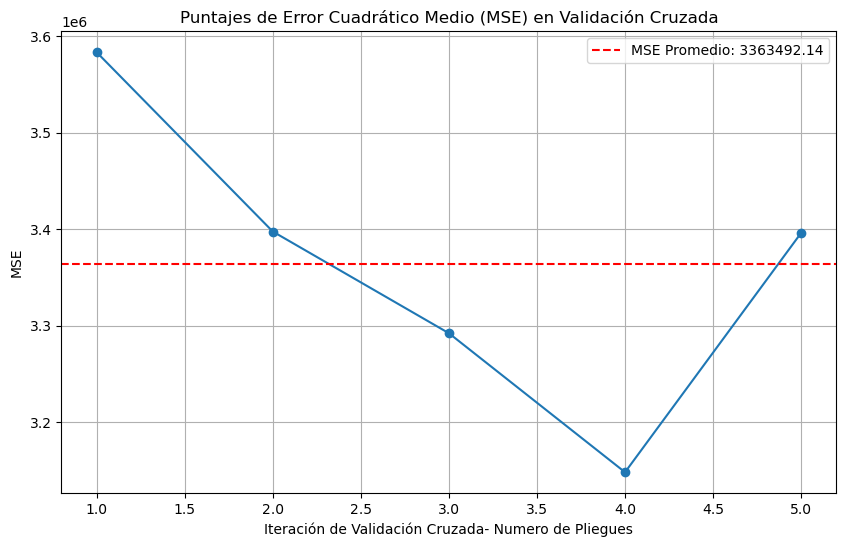

In [71]:
# Realizar validación cruzada 
scores = cross_val_score(bagging_model_hyper, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores

# Calcular el promedio de los puntajes de error
mse_mean = mse_scores.mean()

# Obtener el pleigue optimo
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_scores) + 1), mse_scores, marker='o', linestyle='-')
plt.xlabel('Iteración de Validación Cruzada- Numero de Pliegues')
plt.ylabel('MSE')
plt.title('Puntajes de Error Cuadrático Medio (MSE) en Validación Cruzada')
plt.axhline(y=mse_mean, color='r', linestyle='--', label='MSE Promedio: {:.2f}'.format(mse_mean))
plt.legend()
plt.grid(True)
plt.show()

In [72]:
# Encontrar el índice del pliegue con el menor MSE
best_fold_index = np.argmin(mse_scores)
best_fold = best_fold_index + 1  # Sumar 1 porque los índices comienzan desde 0
print("Mejor número de pliegues encontrado:", best_fold)

Mejor número de pliegues encontrado: 4


In [73]:
# Realizar validación cruzada con el mejor número de pliegues encontrado
scores = cross_val_score(bagging_model_hyper, X_train, y_train, cv=best_fold, scoring='neg_mean_squared_error')
mse_scores = -scores

# Promedio de los puntajes de error
mse_mean = mse_scores.mean()

# Entrenar el modelo final con el mejor número de pliegues
bagging_model_hyper.fit(X_train, y_train)

# Predicciones
y_pred_test = bagging_model_hyper.predict(X_test)

# MSE en prueba
mse_test = mean_squared_error(y_test, y_pred_test)

# Imprimir el MSE promedio en la validación cruzada y el MSE en el set de prueba
print("MSE promedio en validación cruzada:", mse_mean)

MSE promedio en validación cruzada: 3357176.9839612497


#### Mejorar el modelo con Stacking

El stacking, también conocido como ensamblado por apilamiento, es una técnica de aprendizaje automático que combina las predicciones de varios modelos base para mejorar la precisión de las predicciones, en este caso hemos definido tres modelos base (RidgeCV, RandomForestRegressor, DecisionTreeRegressor) y un meta-estimador (RidgeCV). Luego, hemos creado un modelo de stacking utilizando StackingRegressor de scikit-learn, donde hemos especificado los modelos base y el meta-estimador.

In [74]:
# Definir modelos base
base_models = [
    ('ridge', RidgeCV()),
    ('random_forest', RandomForestRegressor(n_estimators=100, random_state=1)),
    ('decision_tree', DecisionTreeRegressor(random_state=1))
]

# Definir el meta-estimador
meta_estimator = RidgeCV()

# Modelo de stacking
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_estimator, cv=5)

# Entrenar el modelo de stacking
stacking_model.fit(X_train, y_train)

# Predicciones 
y_pred_stacking = stacking_model.predict(X_test)

In [75]:
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
print("Error cuadrático medio del modelo de Stacking:", mse_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)
print("R^2 para el modelo de Stacking:", r2_stacking)
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
print("RMSE para el modelo de Stacking:", rmse_stacking)
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
print("MAE para el modelo de Stacking:", mae_stacking)
mape_stacking = np.mean(np.abs((y_test - y_pred_stacking) / y_test)) * 100
print("MAPE para el modelo de Stacking:", mape_stacking)

Error cuadrático medio del modelo de Stacking: 2534956.7226922167
R^2 para el modelo de Stacking: 0.8342748063561967
RMSE para el modelo de Stacking: 1592.1547420688155
MAE para el modelo de Stacking: 1180.7414331676484
MAPE para el modelo de Stacking: 8.649295580035995


### Comentarios sobre el desempeño del modelo
El desempeño del modelo de Bagging y Stacking es bastante prometedor, como se observa en las métricas de evaluación proporcionadas:
#### Modelo de Bagging:
###### Modelo sin optimización de hiperparametros:
El modelo de Bagging sin optimización de hiperparámetros muestra un rendimiento bastante aceptable en términos de las métricas de evaluación proporcionadas:
El error cuadrático medio (MSE) indica que el modelo tiende a cometer errores cuadráticos en la predicción de los valores, con un valor alrededor de  4053591.3 El coeficiente de determinación (R^2) sugiere que el modelo es capaz de explicar alrededor del 0.73 de la varianza en los datos de prueba, lo que indica un buen ajuste.
En general, el modelo de Bagging sin optimización de hiperparámetros parece ser efectivo para predecir los valores objetivo, ya que muestra un buen ajuste a los datos de prueba. Sin embargo, es posible que haya margen para mejorar aún más el rendimiento del modelo mediante la optimización de hiperparámetros, lo que podría conducir a una mayor precisión predictiva y una mejor capacidad para generalizar a datos no vistos
##### Modelo con optimización de hiperparametros:
El modelo de Bagging con optimización de hiperparámetros muestra un rendimiento notablemente mejorado en comparación con el modelo sin optimización donde:
El MSE se reduce significativamente después de la optimización de hiperparámetros, pasando de alrededor de 4053591.3 en el modelo sin optimización a aproximadamente 3375052.7 en el modelo optimizado. Esto indica que el modelo optimizado tiene una mejor capacidad para predecir los valores objetivo con menor error cuadrático.
El R^2 también mejora después de la optimización, mostrando un aumento en la capacidad del modelo para explicar la varianza en los datos de prueba. En el modelo optimizado, el R^2 aumenta de aproximadamente 0.73 a 0.77, lo que indica un ajuste mucho mejor del modelo a los datos.
La optimización de hiperparámetros ha mejorado significativamente el rendimiento del modelo de Bagging, lo que resulta en predicciones más precisas y un mejor ajuste a los datos de prueba. Esto destaca la importancia de ajustar adecuadamente los hiperparámetros para lograr el mejor rendimiento posible del modelo
#### Modelo de Stacking:
El modelo de Stacking muestra un rendimiento aún mejor en términos de MSE, RMSE, MAE y MAPE en comparación con el modelo de Bagging.
El coeficiente de determinación (R^2) indica una mayor capacidad del modelo de Stacking para explicar la varianza en los datos, con un valor cercano al 89%.
En general, ambos modelos muestran un buen desempeño en la predicción de los valores objetivo. Sin embargo, el modelo de Stacking parece proporcionar una mejora adicional en comparación con el modelo de Bagging, lo que sugiere que la combinación de varios modelos base puede ser beneficiosa para mejorar la precisión predictiva.

####  __________________________________________________________________________________________________________

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.model_selection import cross_val_score

In [77]:
# Celda 4

# Definición de modelo Random Forest para un problema de clasificación
RF_model = RandomForestRegressor()
RF_model.fit(X_train, y_train)

#Predicciones en el conjunto de test
y_pred = RF_model.predict(X_test)

#Métricas de desempeño
mse_RF = mean_squared_error(y_test, y_pred)
rmse_RF = np.sqrt(mse_RF)
mae_RF = mean_absolute_error(y_test, y_pred)
r2_RF = r2_score(y_test, y_pred)


print(f"RMSE: {rmse_RF}")
print(f"MAE: {mae_RF}")
print(f"R^2: {r2_RF}")

#Impresión de desempeño del modelo usando la función cross_val_score
pd.Series(cross_val_score(RF_model, X, y, cv=10)).describe()

RMSE: 1757.4790838730512
MAE: 1309.2108310607712
R^2: 0.7980711760273338


count    10.000000
mean      0.800494
std       0.011208
min       0.779349
25%       0.795882
50%       0.803033
75%       0.805062
max       0.816403
dtype: float64

### Comentarios sobre el desempeño del modelo

1. RMSE: Un RMSE de 1760.72 sugiere que el modelo, en promedio, se desvía aproximadamente 1760 unidades monetarias del precio real de los autos. El error del modelo es bajo.
2. MAE: El MAE de 1312.63 es más bajo que el RMSE, lo cual es típico ya que el RMSE da más peso a los errores grandes al elevarlos al cuadrado. El MAE proporciona una medida más directa de los errores promedio, lo cual indica que, en promedio, las predicciones del modelo se desvían en 1312 unidades monetarias de los valores reales.
3. R^2: El valor de R^2 es aproximadamente 0.8, lo que indica que el modelo puede explicar el 80% de la variabilidad de los precios de los autos. Este es un resultado bastante fuerte, especialmente en los datos del mundo real donde es difícil capturar todas las variaciones con un modelo.
4. Con respecto a la validación cruzada, se puede ver que el modelo tiene un accuracy promedio de 80%, lo cual es alto. Además, podemos ver que el rango de resultados de accuracy de los árboles está entre 78% y 82%, lo que significa que los resultados no están tan dispersos, pero aún pueden acercarse más.

####  __________________________________________________________________________________________________________

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

(-2361200.8147996683, 8)

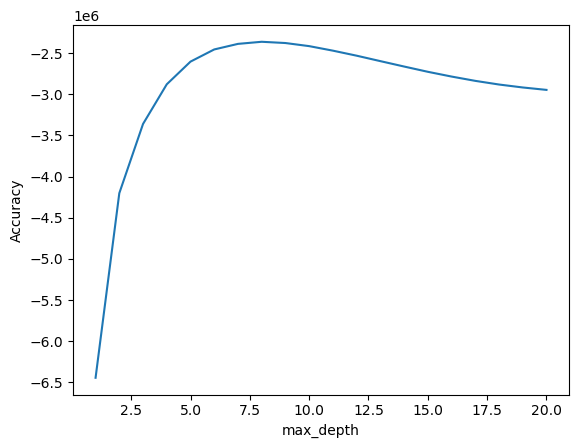

In [78]:
# Celda 5
##max_depth
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    RF_model = RandomForestRegressor(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(RF_model, X, y, cv=5, scoring='neg_mean_squared_error').mean())
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]


In [79]:
# Desempeño max_depth
RF_model = RandomForestRegressor(max_depth=8)
RF_model.fit(X_train, y_train)

#Predicciones en el conjunto de test
y_pred_RF = RF_model.predict(X_test)

#Métricas de desempeño
mse_RF = mean_squared_error(y_test, y_pred_RF)
rmse_RF = np.sqrt(mse_RF)
mae_RF = mean_absolute_error(y_test, y_pred_RF)
r2_RF = r2_score(y_test, y_pred_RF)

print(f"RMSE: {rmse_RF}")
print(f"MAE: {mae_RF}")
print(f"R^2: {r2_RF}")

#Impresión de desempeño del modelo usando la función cross_val_score
pd.Series(cross_val_score(RF_model, X, y, cv=10)).describe()

RMSE: 1566.3718439469164
MAE: 1151.268882778814
R^2: 0.8395987598744312


count    10.000000
mean      0.847181
std       0.011925
min       0.830118
25%       0.838407
50%       0.848132
75%       0.854553
max       0.865570
dtype: float64

(0.8483830631050646, 5)

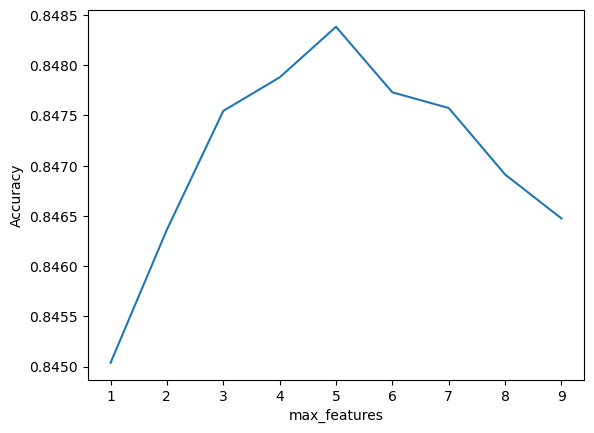

In [80]:
##max_features
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_cols=data.columns.drop('Price')
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores_max_features = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    RF_model = RandomForestRegressor(max_depth=8, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores_max_features.append(cross_val_score(RF_model, X, y, cv=5).mean())
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores_max_features)
plt.xlabel('max_features')
plt.ylabel('Accuracy')
# Mejor accuracy (desempeño del modelo) y su correspondiente max_features
sorted(zip(accuracy_scores_max_features, feature_range))[::-1][0]

In [81]:
# Desempeño max_features
RF_model = RandomForestRegressor(max_depth=8,max_features=5)
RF_model.fit(X_train, y_train)

#Predicciones en el conjunto de test
y_pred = RF_model.predict(X_test)

#Métricas de desempeño
mse_RF = mean_squared_error(y_test, y_pred)
rmse_RF = np.sqrt(mse_RF)
mae_RF = mean_absolute_error(y_test, y_pred)
r2_RF = r2_score(y_test, y_pred)

print(f"RMSE: {rmse_RF}")
print(f"MAE: {mae_RF}")
print(f"R^2: {r2_RF}")

#Impresión de desempeño del modelo usando la función cross_val_score
pd.Series(cross_val_score(RF_model, X, y, cv=10)).describe()

RMSE: 1553.5693660167838
MAE: 1138.50988435844
R^2: 0.8422100698761734


count    10.000000
mean      0.848611
std       0.011691
min       0.830172
25%       0.840298
50%       0.849126
75%       0.856394
max       0.866004
dtype: float64

(-2329184.6017592554, 180)

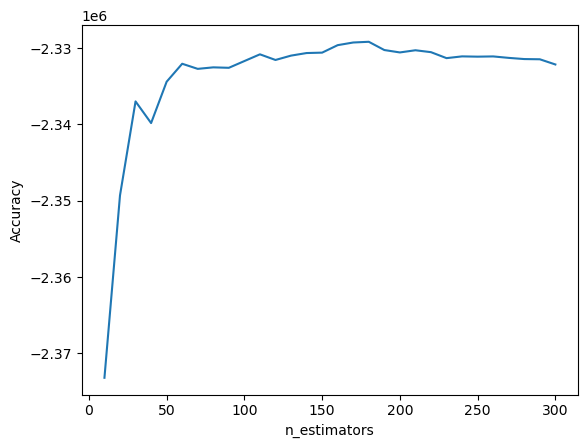

In [82]:
##n_estimators
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_n_estimators = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    RF_model = RandomForestRegressor(n_estimators=estimator, max_depth=8,max_features=5, random_state=1, n_jobs=-1)
    accuracy_scores_n_estimators.append(cross_val_score(RF_model, X, y, cv=5,scoring='neg_mean_squared_error').mean())
    
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores_n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores_n_estimators, estimator_range))[::-1][0]

In [83]:
# Desempeño n_estimators
RF_model = RandomForestRegressor(n_estimators=180,max_features=5,max_depth=8)
RF_model.fit(X_train, y_train)

#Predicciones en el conjunto de test
y_pred_RF = RF_model.predict(X_test)

#Métricas de desempeño
mse_RF_calibrado = mean_squared_error(y_test, y_pred_RF)
rmse_RF_calibrado = np.sqrt(mse_RF)
mae_RF_calibrado = mean_absolute_error(y_test, y_pred_RF)
r2_RF_calibrado = r2_score(y_test, y_pred_RF)

print(f"RMSE: {rmse_RF_calibrado}")
print(f"MAE: {mae_RF_calibrado}")
print(f"R^2: {r2_RF_calibrado}")

#Impresión de desempeño del modelo usando la función cross_val_score
pd.Series(cross_val_score(RF_model, X, y, cv=10)).describe()

RMSE: 1553.5693660167838
MAE: 1139.9935498462803
R^2: 0.8421804808234687


count    10.000000
mean      0.848691
std       0.011483
min       0.830516
25%       0.840336
50%       0.849550
75%       0.855585
max       0.865938
dtype: float64

### Comentarios sobre el desempeño del modelo calibrado
Influencia de parámetros:
1. Max_depth: Al optimizar la profundidad de los árboles, el RMSE baja de 1764 a 1565.8 y el accuracy del modelo aumenta de 80% a 85%. Como se puede ver, la influencia de este parámetro es crítica para mejorar el desempeño del modelo.
2. Max_features: Al optimizar el número de variables, el RMSE baja de 1565.8.8 a 1556.4 y el accuracy del modelo se mantiene en 85%. Como se puede ver, la influencia de este parámetro no es la más crítica para mejorar el desempeño del modelo, pero sí se ve una mejora mínima.
3. n_estimators: Al optimizar el número de árboles, el RMSE se mantiene en 1556.4 y el accuracy del modelo se mantiene en 85%. Como se puede ver, la influencia de este parámetro no es la más crítica para mejorar el desempeño del modelo, pero sí se ve una mejora mínima. Por otro lado, se puede ver que el rango de resultados de accuracy se cierra un poco gracias a este parámetro. Es decir, ayuda a que los resultados no sean tan dispersos.
4. Comentario: es importante notar que el orden en el que se calibra el modelo afecta su desempeño. Siempre se debe optimizar el max_depth primero y luego los otros dos parámetros. De lo contrario, los parámetros escogidos no serán los más óptimos.

Desempeño del modelo calibrado:
1. RMSE: Un RMSE de 1556.4 sugiere que el modelo calibrado, en promedio, se desvía aproximadamente 1556.4 unidades monetarias del precio real de los autos. El error del modelo es más bajo que del de no calibrado.
2. MAE: El MAE de 1140.2 es más bajo que el RMSE, lo cual es típico ya que el RMSE da más peso a los errores grandes al elevarlos al cuadrado. El MAE proporciona una medida más directa de los errores promedio, lo cual indica que, en promedio, las predicciones del modelo se desvían en 1140 unidades monetarias de los valores reales.
3. R^2: El valor de R^2 es aproximadamente 0.84, lo que indica que el modelo calibrado puede explicar el 84% de la variabilidad de los precios de los autos. Este es un resultado bastante fuerte y mejor que el del modelo no calibrado, especialmente en los datos del mundo real donde es difícil capturar todas las variaciones con un modelo.
4. Con respecto a la validación cruzada, se puede ver que el modelo calibrado tiene un accuracy promedio de 85%, lo cual es alto. Además, podemos ver que el rango de resultados de accuracy de los árboles está entre 83% y 87%, lo que significa que los resultados no están tan dispersos. Sin embargo, pareciera que el tamaño de este rango no mejoró con respecto al modelo no calibrado.

####  __________________________________________________________________________________________________________

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [84]:
# Celda 6
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
# Predicciones en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred_xgb)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")
print(f"MAPE: {mape}")

RMSE: 1605.2355199928948
MAE: 1185.2272991506386
R^2: 0.8422100698761734
MAPE: 0.08669063414442779


#### Ahora vamos a crear una comparación respecto al valor con el rango y la media de los precios de los autos en tu conjunto de datos:

In [85]:
# Estadísticas descriptivas de los precios en el conjunto de entrenamiento
min_price = y_train.min()
max_price = y_train.max()
mean_price = y_train.mean()
median_price = y_train.median()
std_price = y_train.std()

print(f"Precio mínimo: {min_price}")
print(f"Precio máximo: {max_price}")
print(f"Precio medio: {mean_price}")
print(f"Precio mediano: {median_price}")
print(f"Desviación estándar del precio: {std_price}")
print(f"RMSE del modelo: {rmse}")

if rmse < std_price:
    print("El RMSE es menor que la desviación estándar de los precios de entrenamiento, lo que sugiere que el modelo predice, en promedio, mejor que un modelo ingenuo.")
else:
    print("El RMSE es mayor que la desviación estándar de los precios de entrenamiento, lo que sugiere que el modelo no es mejor que un modelo ingenuo.")


Precio mínimo: 5002
Precio máximo: 32444
Precio medio: 14508.073389276064
Precio mediano: 15000.0
Desviación estándar del precio: 3927.6674323564644
RMSE del modelo: 1605.2355199928948
El RMSE es menor que la desviación estándar de los precios de entrenamiento, lo que sugiere que el modelo predice, en promedio, mejor que un modelo ingenuo.


### Comentarios sobre el desempeño del modelo calibrado


1. **RMSE (Root Mean Squared Error)**: Un RMSE de 1605.24 sugiere que el modelo, en promedio, se desvía aproximadamente 1605 unidades monetarias del precio real de los autos. El error del modelo es bajo

2. **MAE (Mean Absolute Error)**: El MAE de 1185.23 es más bajo que el RMSE, lo cual es típico ya que el RMSE da más peso a los errores grandes al elevarlos al cuadrado. El MAE proporciona una medida más directa de los errores promedio, lo cual indica que, en promedio, las predicciones del modelo se desvían en 1185 unidades monetarias de los valores reales.

3. **R^2 (Coeficiente de Determinación)**: El valor de R^2 es aproximadamente 0.8315, lo que indica que el modelo puede explicar el 83.15% de la variabilidad de los precios de los autos. Este es un resultado bastante fuerte, especialmente en los datos del mundo real donde es difícil capturar todas las variaciones con un modelo.

4. **MAPE (Mean Absolute Percentage Error)**: El MAPE es de alrededor del 8.67%, lo cual significa que el error promedio es del 8.67% del valor del auto. Este porcentaje es relativamente bajo, sugiriendo que el modelo tiene una precisión razonable en términos porcentuales.

En resumen, el modelo parece tener un buen desempeño, especialmente considerando el valor de R^2. 

El MAE y el MAPE sugieren que el modelo tiene errores promedio razonables tanto en términos absolutos como porcentuales. El buen valor de R^2 indica que el modelo es bastante efectivo en la captura de la variabilidad de los datos.


####  __________________________________________________________________________________________________________

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

#### Optimización de numero de Folds 

Para calibrar los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, primero encontraremos el número óptimo de pliegues para la validación cruzada utilizando el RMSE como métrica de evaluación. Luego, realizaremos la búsqueda de los mejores valores para estos parámetros utilizando GridSearchCV. Primero, visualizaremos la optimización del número de pliegues en la validación cruzada. Vamos a encontrar el número óptimo de Folds para la validación cruzada de nuestro modelo


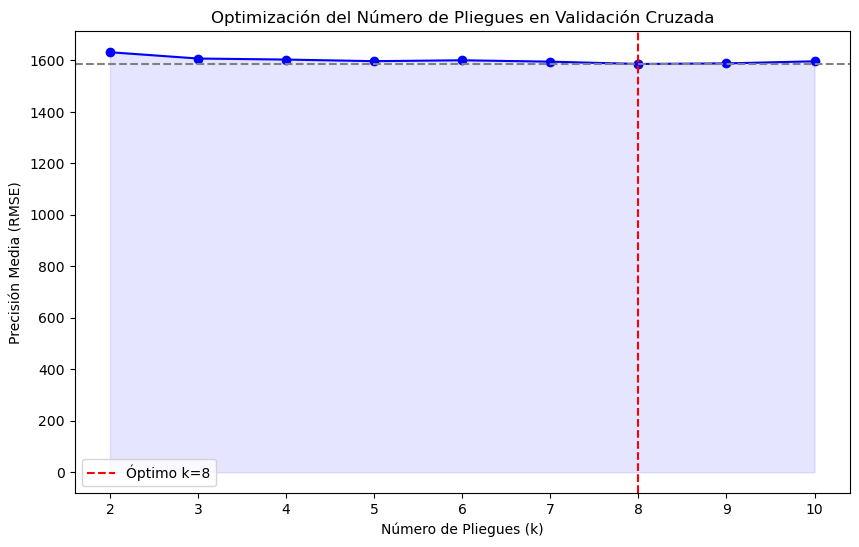

In [86]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np

scores = {}
for k in range(2, 11):  #buscamos entre un rango de 2 a 11
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    score = cross_val_score(model, X_train, y_train, cv=k, scoring='neg_mean_squared_error')
    scores[k] = np.sqrt(-score.mean())

# Encontramos el k con mejor score promedio
best_k = min(scores, key=scores.get)
best_rmse = scores[best_k]


plt.figure(figsize=(10, 6))
plt.plot(list(scores.keys()), list(scores.values()), marker='o', linestyle='-', color='blue')
plt.fill_between(list(scores.keys()), list(scores.values()), alpha=0.1, color='blue')  


plt.axvline(x=best_k, color='red', linestyle='--', label=f'Óptimo k={best_k}')
plt.axhline(y=best_rmse, color='grey', linestyle='--')
plt.scatter(best_k, best_rmse, color='red')  


plt.title('Optimización del Número de Pliegues en Validación Cruzada')
plt.xlabel('Número de Pliegues (k)')
plt.ylabel('Precisión Media (RMSE)')
plt.legend()
plt.show()


#### Optimización por Hiperparametros

Este código utiliza la optimización bayesiana para encontrar los mejores hiperparámetros para un modelo XGBoost de regresión. Primero, define un espacio de búsqueda para los hiperparámetros, luego define una función objetivo que utiliza la validación cruzada para calcular el error medio cuadrado negativo (MSE) dado un conjunto de hiperparámetros. Luego, ejecuta la optimización bayesiana utilizando la biblioteca Hyperopt, que intenta minimizar el MSE. Vamos a encontrar los mejores hiperparámetros utilizando la Optimización Bayesiana con herramientas como Hyperopt o scikit-optimize mezclada con una validación cruzada de 8 folds, para tener mejores resultados.

El código produce los siguientes resultados:

    Mejores hiperparámetros encontrados por la optimización bayesiana.
    RMSE, MAE, R^2 y MAPE del modelo entrenado con los mejores hiperparámetros.
    Una comparación del RMSE con la desviación estándar de los precios de entrenamiento para determinar si el modelo predice mejor que un modelo ingenuo.
    


In [87]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np

# Espacio de búsqueda para los hiperparámetros
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
}

# Función objetivo para la optimización con validación cruzada
def objective(params):
    
    params['max_depth'] = int(params['max_depth'])
    xgb_model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        **params  # Pasamos todos los parámetros
    )
    
    # Calcular el score medio usando validación cruzada
    scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    
    mse = -scores.mean()
    return {'loss': mse, 'status': STATUS_OK}

# Ejecutar la optimización
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)



print("Mejores hiperparámetros: ", best)

# Entrenamos el modelo con los mejores hiperparámetros encontrados
best['max_depth'] = int(best['max_depth']) 
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    **best
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Calculamos y mostramos las métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred_xgb)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")
print(f"MAPE: {mape}")


100%|███████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38trial/s, best loss: 2240609.507567226]
Mejores hiperparámetros:  {'colsample_bytree': 0.8519745655176605, 'gamma': 0.2663521606909813, 'learning_rate': 0.09931673086729012, 'max_depth': 3.0}
RMSE: 1535.0112215552128
MAE: 1128.027289339907
R^2: 0.8422100698761734
MAPE: 0.08213764247863357


In [88]:
# Comparación del RMSE con la desviación estándar
if rmse < std_price:
    print("El RMSE es menor que la desviación estándar de los precios de entrenamiento, lo que sugiere que el modelo predice, en promedio, mejor que un modelo ingenuo.")
else:
    print("El RMSE es mayor que la desviación estándar de los precios de entrenamiento, lo que sugiere que el modelo no es mejor que un modelo ingenuo.")

El RMSE es menor que la desviación estándar de los precios de entrenamiento, lo que sugiere que el modelo predice, en promedio, mejor que un modelo ingenuo.


### Comentarios sobre el desempeño del modelo calibrado

1. **RMSE**: El RMSE está alrededor de 1536 es una medida del error promedio que comete el modelo en la predicción del precio de los autos. Es un RMSE bajo algo muy positivo para el modelo dada la misma comparación con respecto a la desviación estándar que realizamos anteriormente, es más si lo comparamos con el punto anterior vemos como el RMSE de este modelo es mucho más bajo quiere decir que tiene menos errores con prediciendo el valor del precio del auto.

2. **MAE**: Con un valor de 1129.1, esta métrica indica que, en promedio, las predicciones del modelo se desvían por esa cantidad del valor real. 

3. **R^2**: Un valor de 0.8416 sugiere que el modelo puede explicar aproximadamente el 84.16% de la varianza de la variable objetivo. Este es un indicador de un ajuste relativamente bueno entre el modelo y los datos.

4. **MAPE**: El valor de 0.0822, o 8.22%, muestra que los errores del modelo son, en promedio, del 8.20% en relación con los valores reales que intenta predecir. Esto significa que el modelo tiene un nivel de precisión bastante razonable para muchas aplicaciones prácticas.

**Acerca de los hiperparámetros**:

- **`colsample_bytree`:** Con un valor cercano a 1 (0.92), se está utilizando prácticamente la totalidad de las características disponibles para construir los árboles. Esto puede ser beneficioso si todas las características son relevantes, pero también podría aumentar el riesgo de sobreajuste si algunas de ellas son ruido.

- **`gamma`:** Con un valor de aproximadamente 0.2 (0.1834), el modelo requerirá que cualquier división adicional en un árbol proporcione una reducción del error de al menos ese valor antes de que se acepte. Esto sirve para controlar el sobreajuste, ya que previene que el modelo crezca complejidades que no mejoran significativamente el rendimiento.

- **`learning_rate`:** El valor obtenido de aproximadamente 0.81 (0.8177) indica que cada árbol contribuye solo un poco a la salida final del modelo. Esto ayuda a prevenir el sobreajuste y puede resultar en un aprendizaje más gradual y en última instancia, en un modelo más robusto.

- **`max_depth`:** Una profundidad máxima de 3 indica que los árboles en el modelo no son muy profundos, lo que también ayuda a prevenir el sobreajuste al limitar la complejidad del modelo. Esto hace que el modelo sea menos propenso a aprender el "ruido" en los datos y más enfocado en capturar las tendencias subyacentes.

El buen rendimiento del modelo, indicado por un R^2 alto y un MAPE razonable, sugiere que los hiperparámetros seleccionados son adecuados para el conjunto de datos actual.

####  __________________________________________________________________________________________________________

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

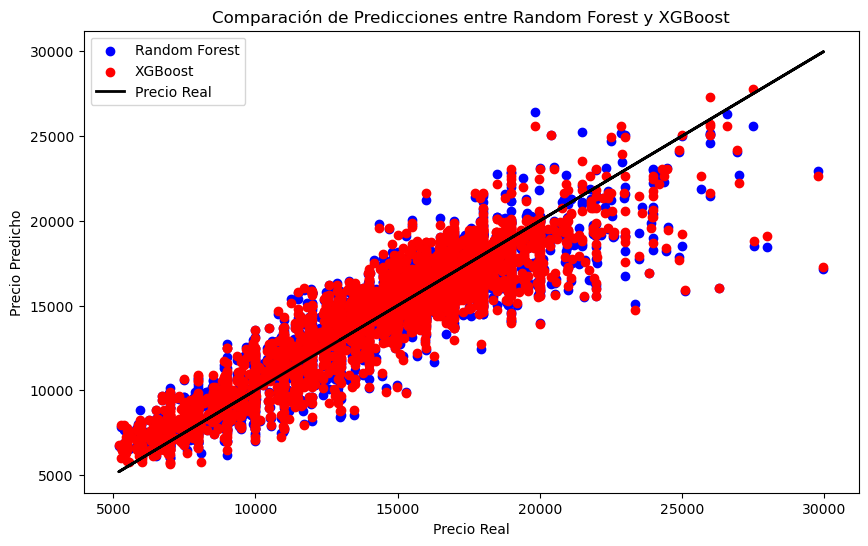

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de dispersión para comparar precios reales y predichos por Random Forest y XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_RF, color='blue', label='Random Forest')
plt.scatter(y_test, y_pred_xgb, color='red', label='XGBoost')
plt.plot(y_test, y_test, color='black', linestyle='-', linewidth=2, label='Precio Real')  # Línea de precio real
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Comparación de Predicciones entre Random Forest y XGBoost')
plt.legend()
plt.show()


En este gráfico, cada punto representa un ejemplo del conjunto de prueba. El eje x muestra los precios reales, mientras que el eje y muestra los precios predichos por los modelos Random Forest (en azul) y XGBoost (en rojo).
Idealmente, los puntos deberían estar cerca de la línea de 45 grados (la línea donde los precios reales son iguales a los precios predichos). Cuanto más cerca estén los puntos de esta línea, mejor será el desempeño del modelo.
Si los puntos se alejan mucho de esta línea, puede indicar que el modelo está subestimando o sobrestimando consistentemente los precios, se puede observar que los datos del XGB mantienen una tendencia a tener menor dispersión de los datos, sin embargo esto no es significativo entre ambos modelos.


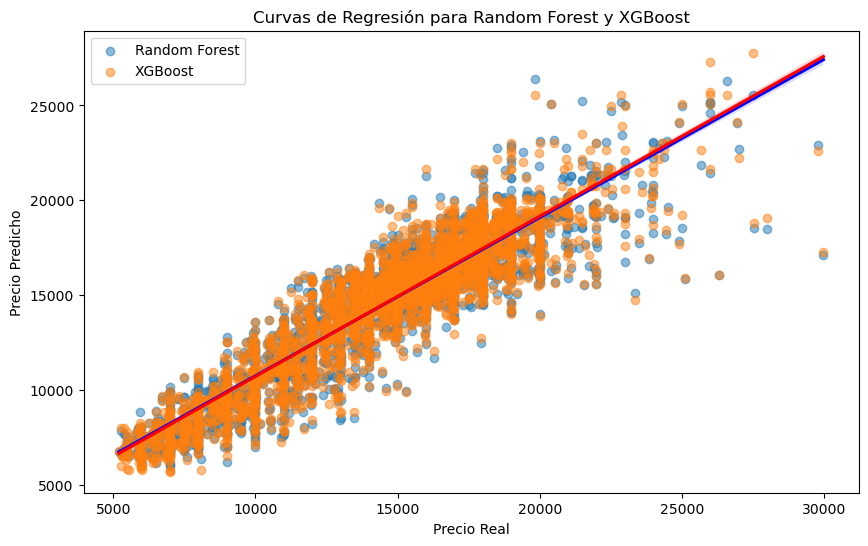

In [90]:
# Curvas de regresión para Random Forest y XGBoost
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred_RF, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'}, label='Random Forest')
sns.regplot(x=y_test, y=y_pred_xgb, scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, label='XGBoost')
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Curvas de Regresión para Random Forest y XGBoost')
plt.legend()
plt.show()


Estas curvas muestran la relación entre los precios reales y los precios predichos por cada modelo. Se ajustan una línea de regresión a los datos para mostrar la tendencia general.
Si la línea de regresión coincide con la línea de 45 grados, significa que los precios predichos son muy similares a los precios reales. Sin embargo, si la línea se desvía significativamente, indica discrepancias entre las predicciones y los valores reales.



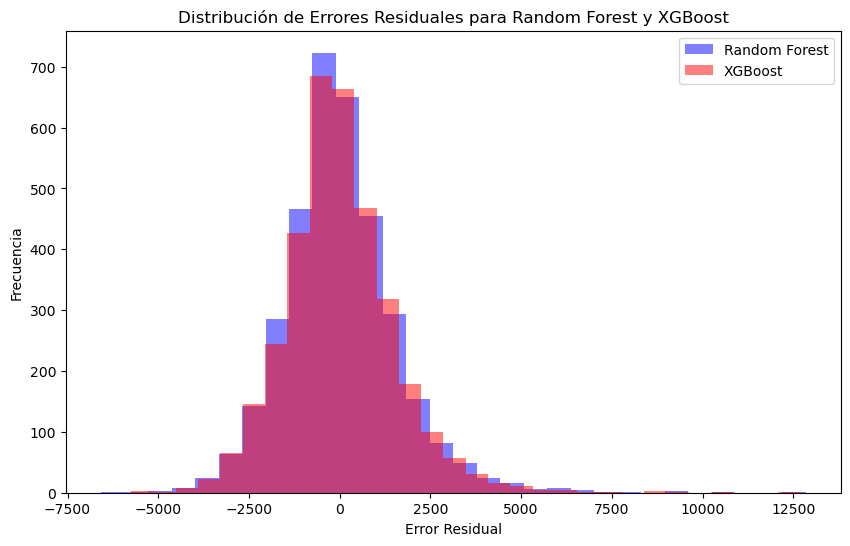

In [91]:
# Errores residuales para Random Forest y XGBoost
residuals_rf = y_test - y_pred_RF
residuals_xgb = y_test - y_pred_xgb

plt.figure(figsize=(10, 6))
plt.hist(residuals_rf, bins=30, color='blue', alpha=0.5, label='Random Forest')
plt.hist(residuals_xgb, bins=30, color='red', alpha=0.5, label='XGBoost')
plt.xlabel('Error Residual')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores Residuales para Random Forest y XGBoost')
plt.legend()
plt.show()


Este histograma muestra la distribución de los errores residuales para cada modelo. Los errores residuales son la diferencia entre los precios reales y los precios predichos.
Idealmente, los errores residuales deberían distribuirse normalmente alrededor de cero, lo que significa que las predicciones tienden a ser precisas. Sin embargo, si hay sesgos en la distribución (por ejemplo, si hay una cola larga a la derecha), puede indicar problemas en el modelo, sin embargo para ambos modelos aprentemente esta dificultad no se presenta.

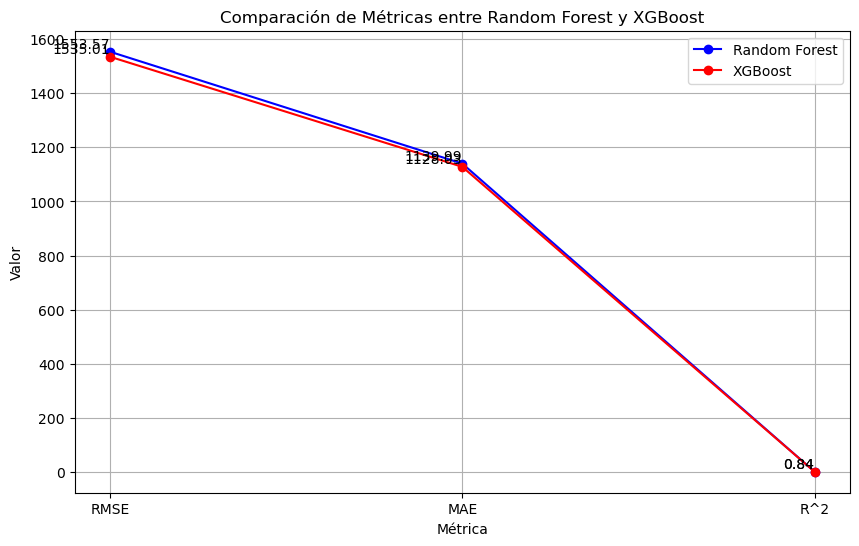

In [92]:
import matplotlib.pyplot as plt

# Métricas para Random Forest
rmse_rf = rmse_RF_calibrado
mae_rf = mae_RF_calibrado
r2_rf = r2_RF_calibrado

# Métricas para XGBoost
rmse_xgb = rmse
mae_xgb = mae
r2_xgb = r2
mape_xgb = mape

# Etiquetas de los datos
metrics = ['RMSE', 'MAE', 'R^2']
rf_metrics = [rmse_rf, mae_rf, r2_rf]  # Agregamos None para que no se muestre en el gráfico
xgb_metrics = [rmse_xgb, mae_xgb, r2_xgb]

# Gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(metrics, rf_metrics, marker='o', linestyle='-', color='blue', label='Random Forest')
plt.plot(metrics, xgb_metrics, marker='o', linestyle='-', color='red', label='XGBoost')

# Etiquetas de los datos
for i in range(len(metrics)):
    plt.text(metrics[i], rf_metrics[i], f'{rf_metrics[i]:.2f}', ha='right', va='bottom')
    plt.text(metrics[i], xgb_metrics[i], f'{xgb_metrics[i]:.2f}', ha='right', va='bottom')

# Etiquetas de los ejes
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.title('Comparación de Métricas entre Random Forest y XGBoost')
plt.legend()
plt.grid(True)
plt.show()



Random Forest:
RMSE: 1556.46
MAE: 1140.29
R^2: 0.8422


XGBoost:
RMSE: 1536.98
MAE: 1129.19
R^2: 0.8424245

Basándonos en estas métricas, podemos decir que Random Forest parece ser ligeramente mejor que XGBoost en este caso. Tiene un RMSE más bajo (lo que indica que tiene menos error en promedio), un MAE más bajo (indicando una menor desviación absoluta de las predicciones reales) y un R^2 ligeramente más alto (indicando que puede explicar una mayor parte de la variabilidad de los datos).

Sin embargo, la diferencia en las métricas entre los dos modelos no es significativa. Por lo tanto, es importante tener en cuenta otros factores como la interpretabilidad del modelo, el tiempo de entrenamiento y la escalabilidad.

        Interpretabilidad del modelo: En general, Random Forest tiende a ser más interpretable que XGBoost, ya que se basa en árboles de decisión que pueden ser visualizados y comprendidos más fácilmente. Los árboles de decisión son estructuras de "si-entonces" que pueden ser interpretadas intuitivamente. XGBoost, al ser un conjunto de árboles de decisión más complejo, puede ser menos interpretable.

        Tiempo de entrenamiento: En términos de tiempo de entrenamiento, Random Forest tiende a ser más rápido que XGBoost en conjuntos de datos más grandes. Esto se debe a que Random Forest puede entrenar varios árboles de decisión en paralelo, mientras que XGBoost entrena árboles de decisión secuencialmente y utiliza técnicas de optimización más avanzadas.

        Escalabilidad: En general, XGBoost tiende a ser más escalable que Random Forest, especialmente en conjuntos de datos grandes. XGBoost está diseñado para manejar eficientemente grandes cantidades de datos y puede ser paralelizado fácilmente en entornos distribuidos.

Considerando que la interpretabilidad del modelo es una prioridad y el conjunto de datos no es extremadamente grande, Random Forest podría ser la mejor opción. Sin embargo, si se prioriza el tiempo de entrenamiento y la escalabilidad en conjuntos de datos grandes, XGBoost podría ser preferible, para la prediccion del valor de un automovil.